In [1]:
import pandas
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks

In [2]:
# 1 image has 16x16 pixels = 256 pixels
pixels = ["pixel_{0}".format(i) for i in range(36)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,6,6), axis=-1)


store_train = pandas.HDFStore("pixelTrain.h5")

df_train = store_train.select("df",stop=-1)
df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]


store_test = pandas.HDFStore("pixelTrain30k.h5")

df_test = store_test.select("df",stop=-1)
df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
images_test = to_image(df_test)


# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

In [3]:
# Check that all are merged hits i.e. isSharedHit=1
print df_test['isSharedHit'].head()
print df_train['isSharedHit'].head()

25    1
30    1
39    1
69    1
92    1
Name: isSharedHit, dtype: int32
4     1
9     1
10    1
12    1
21    1
Name: isSharedHit, dtype: int32


In [4]:
print df_test.shape
print df_train.shape

# Remove overlap between train and test data
df_combined = pandas.concat([df_test, df_train]).drop_duplicates(keep=False)
df_combined.shape


# New combined files
df_train=df_combined.sample(frac=0.6)
df_test=df_combined.drop(df_train.index)

# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]


images_train = to_image(df_train)
images_test = to_image(df_test)

(58, 42)
(267, 42)


In [5]:
print df_test.shape
print df_train.shape

(114, 42)
(173, 42)


In [6]:
# Adding isMergedHit column 

merged_hit = df_train["nUniqueSimTracksInSharedHit"]>1
merged_int = merged_hit.astype(int)
df_train.insert(0, "isMergedHit", merged_int, True)

#df_train.head()

merged_hit_test = df_test["nUniqueSimTracksInSharedHit"]>1
merged_int_test = merged_hit_test.astype(int)
df_test.insert(0, "isMergedHit", merged_int_test, True)

df_test.head()

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35
69,1,1,1.330709,-2.043563,1.330709,2.0,0.043240,0.0,0.0,0.087983,...,0.083277,0.139740,0.000000,0.0,0.0,0.0,0.045860,0.090908,0.0,0.0
92,0,1,1.927646,-2.203123,1.927646,1.0,0.016287,0.0,0.0,0.000000,...,0.000000,0.403630,0.056244,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
119,1,1,4.657765,-1.873906,4.657765,2.0,0.005257,0.0,0.0,0.000000,...,0.254677,0.101919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
349,0,1,1.930894,-2.201330,1.930894,1.0,0.014368,0.0,0.0,0.000000,...,0.067900,0.033405,0.000000,0.0,0.0,0.0,0.126999,0.017108,0.0,0.0
369,1,1,13.460906,0.522433,13.460906,2.0,0.000735,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [7]:
# Check for overlap
pandas.merge(df_train, df_test, on=[x for x in df_train.columns], how='inner')

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35


In [8]:
from sklearn.model_selection import train_test_split
X = df_train.iloc[:,np.r_[1:4, 6:43]]
Y = df_train['isMergedHit']
#train_SharedHit = images_train['isMergedHit']

x_final_test = df_test.iloc[:,np.r_[1:4, 6:43]]
y_final_test = df_test['isMergedHit']

# Splitting train data into training and validation datasets
x_train, x_test, y_train_v, y_test_v = train_test_split(X, Y, test_size = 0.4, random_state = 2)

print Y.shape
print X.shape

(173,)
(173, 40)


In [9]:
# Random Forest
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Defining Model

clf = RandomForestClassifier(n_estimators = 100, warm_start=True, bootstrap = True)

clf.fit(x_train, y_train_v)

# Predictions on training 
y_pred_train = clf.predict(x_train)

# Predictions for test
y_pred_test = clf.predict(x_test)

# Training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_train_v, y_pred_train))

# Test data metrics
print("Validation test data metrics:")
print(sklearn.metrics.classification_report(y_test_v, y_pred_test))

RF_validation_accuracy = accuracy_score(y_test_v, y_pred_test)
print RF_validation_accuracy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Training metrics:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        39
          1       1.00      1.00      1.00        64

avg / total       1.00      1.00      1.00       103

Validation test data metrics:
             precision    recall  f1-score   support

          0       0.92      0.87      0.89        38
          1       0.85      0.91      0.88        32

avg / total       0.89      0.89      0.89        70

0.8857142857142857


In [10]:
# Predictions on test set
y_pred_final_test = clf.predict(x_final_test)

# Final test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_final_test, y_pred_final_test))

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print 'Accuracy Score'
print accuracy_score(y_final_test, y_pred_final_test)

Test data metrics:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97        48
          1       0.98      0.97      0.98        66

avg / total       0.97      0.97      0.97       114

Accuracy Score
0.9736842105263158


In [11]:
# Not very important, confusion matrix plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print 'Confusion Matrix'
mat = confusion_matrix(y_final_test, y_pred_final_test) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Confusion Matrix


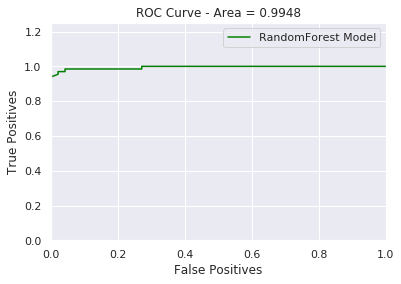

In [12]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Getting rid of warning for .as_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ROC Curve for RandomForest
probs = clf.predict_proba(x_final_test)[:,1]

merged_array = df_test.as_matrix(columns=df_test.columns[:1])

fpr, tpr, thresholds = roc_curve(merged_array, probs)
auc = metrics.auc(fpr,tpr)
auc = round(auc, 4)
plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot(fpr,tpr, color='green', label='RandomForest Model')
plt.title("ROC Curve - Area = "+str(auc))
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.show()

shared hits with at least 2 sim tracks:
0.554913294798


Text(0.5,1,'nUniqueSimTracksInSharedHit')

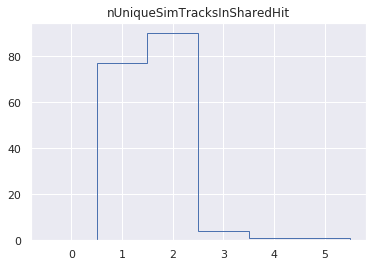

In [13]:
print "shared hits with at least 2 sim tracks:"
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"],histtype="step",bins=6,range=(-0.5,5.5))
plt.title("nUniqueSimTracksInSharedHit")

0.554913294798


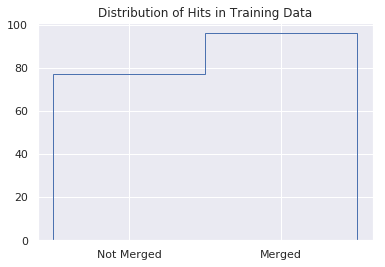

In [14]:
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"]>1,histtype="step",bins=2,range=(-0.5,1.5))
plt.title("Distribution of Hits in Training Data")
plt.xticks([0,1],("Not Merged","Merged"))
plt.savefig("merged_dist.png")
plt.savefig("merged_dist.pdf")

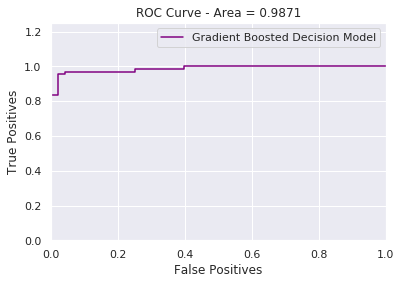

In [15]:
# Gradient Boosted Decision
from sklearn.ensemble import GradientBoostingClassifier

bdt = GradientBoostingClassifier(warm_start = True, max_leaf_nodes = 3)
#bdt = GradientBoostingClassifier(max_depth = 5)
bdt.fit(x_train, y_train_v)

# ROC Curve for BDT
probs_BDT = bdt.predict_proba(x_final_test)[:,1]

merged_array_BDT = df_test.as_matrix(columns=df_test.columns[:1])

fpr, tpr, thresholds = roc_curve(merged_array_BDT, probs_BDT)
auc_BDT = metrics.auc(fpr,tpr)
auc_BDT = round(auc_BDT, 4)
plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot(fpr,tpr, color='purple', label='Gradient Boosted Decision Model')
plt.title("ROC Curve - Area = "+str(auc_BDT))
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


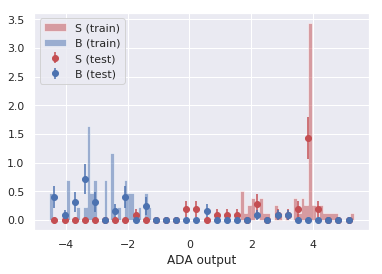

In [16]:
decisions = bdt.decision_function(x_test)

def compare_train_test(bdt, x_train, y_train_v, x_test, y_test_v, bins=30):
    decisions = []
    for X,y in ((x_train, y_train_v), (x_test, y_test_v)):
        d1 = bdt.decision_function(X[y>0.5]).ravel()
        d2 = bdt.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("ADA output")
    plt.legend(loc='best')
    
compare_train_test(bdt, x_train, y_train_v, x_test, y_test_v)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [17]:
if auc_BDT > auc:
    print "BDT classifier performed better"
    print "BDT Area = "+str(auc_BDT)
else:
    print "RandomForest classifier performed better"
    print "RF Area = "+str(auc)

RandomForest classifier performed better
RF Area = 0.9948


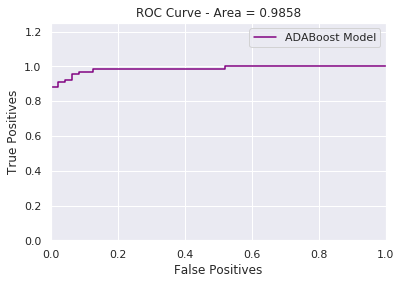

<Figure size 432x288 with 0 Axes>

In [18]:
# ADABoost Classifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 100)
ada.fit(x_train, y_train_v)

probs_ADA = ada.predict_proba(x_final_test)[:,1]

#ROC Curve

merged_array_ADA = df_test.as_matrix(columns=df_test.columns[:1])

fpr, tpr, thresholds = roc_curve(merged_array_ADA, probs_ADA)
auc_ADA = metrics.auc(fpr,tpr)
auc_ADA = round(auc_ADA, 4)
plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot(fpr,tpr, color='purple', label='ADABoost Model')
plt.title("ROC Curve - Area = "+str(auc_ADA))
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.show()
plt.savefig("ADABoost_ROC.png")

In [19]:
if auc_ADA > auc_BDT > auc:
    print 'ADA Boost performed best'
    print 'AUC = '+str(auc_ADA)
elif auc_BDT > auc_ADA > auc:
    print 'BDT performed best'
    print 'AUC = '+str(auc_BDT)
elif auc_ADA > auc > auc_BDT:
    print 'ADA Boost performed best'
    print 'AUC = '+str(auc_ADA)
elif auc_BDT > auc > auc_ADA:
    print 'BDT performed best'
    print 'AUC = '+str(auc_BDT)
elif auc > auc_ADA > auc_BDT:
    print 'Random Forest performed best'
    print 'AUC = '+str(auc)
else:
    print 'Random Forest performed best'
    print 'AUC = '+str(auc)    

Random Forest performed best
AUC = 0.9948
